In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
import torch 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
xs = []
ys = []

block_size = 3 # block size defines the number of characters to pass as input in order to predict the next character.
for w in words[:5]: 
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        xs.append(context)
        ys.append(stoi[ch])
        print(''.join([itos[c] for c in context]), '--->', ch)
        context = context[1:] + [stoi[ch]] # This is a sliding window which adds the current ch to context so that the next character becomes the expected outcome


X = torch.tensor(xs)
Y = torch.tensor(ys)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.shape

(torch.Size([32, 3]), torch.Size([32, 3]))

### What does the shape of X signify?
X shape is [32, 3]. The block size that we have taken is 3, which means we need 3 characters as input to predict the next character. 
Hence, each input has 3 character indices, each index representing 1 character. 
We have 32 such inputs, that is, the batch size is 32. 

### What does the shape of Y signify? 
Y shape is [32], which indicates the expected character for each input. The model will predict 1 character as its output, hence there will be in total of 32 characters which are expected, one for each input. 

## What is our goal here? 
The goal is as simple as it was in our trigram model. We want to build a neural net which takes the input characters of count = block size and it outputs the probabilities of all 27 characters as the next character. 
The output probabilities are the <i>Likelyhood</i> of each character to be the next character in the sequence. 

The next goal will be to increase the likelyhood of the character which, according to the ys vector is the expected next character in the sequence, out of all 27 possible ones.

### How to feed the input to the network? 
As seen above, each input is of length equal to block size, 3 at the moment. So we have 3 indices of characters which are integers. 
We cannot simply feed these integer values to the model. One way to do this is, we convert each index into one hot encoded vector. That will give us a vector of shape [3, 27], since each index will be a vector of length 27 (since there are 27 possible characters). 

Ofc, we cannot feed 3 different vectors of length 27, as a single input. So one way to deal with this is, we <i>Flatten</i> these 3 vectors and create a vector of shape [1, 81]. And that will be perfectly fine; at least for the current usecase. 

But let me familiarise you with a problem with this approach briefly with an example, and we will discuss it at greater length later.
The current dictionary/vocabulary or corpus that we have right now is of size 27 (since there are 27 possible characters, and each expected next character is supposed to be one of these 27 ones).

The one hot encoded vector of each index is therefore length 27 (it is also known as, of 27 dimentionality). Depending on how many characters we feed at the same time, say n, the actual input vector becomes of length 27 times n (where n is 3 right now).

Imagine a scenario where the vocabulary is of massive size, say 20,000. And we feed say 3 inputs at a time. So the length of the input vector would be whopping 60,000. In a fully connected network, this would require us to have 60,000 neurons in the first layer. 

This is known as the <b><i>Curse of dimentionality</i></b>. We will look at it more closely later. 

#### So what can we do? 
One thing we can do is, we fix the dimension size, say m, of the vector and try to represent each index with with a vector having m dimensions. 

I found the word <i>Dimensions</i> a little confusing here. In mathematics, when we say 3 dimensions, we expect a matrix having 3 dimensions of varied lengths. Say x, y, z. 
If we say m = 30 in the above example, it simply means that the 1D vector will have 30 features (the length of the vector will be 30), where each value of the vector represents a feature. Each value does represent a point in a vector space of 30 dimensions but we do not define the vector with 30 elements in the shape of the vector, each with its own length. I find it important to point this out, in order to prevent the same confusion that I went through. 

Another way to look at it is, there are 30 axises, each with length of 1. If we flatten that matrix, we will get a 1D vector of length 30.

The vectors of fixed dimension size m, is known as an embedding. More on embeddings later. Let's define the embeddings first. 
Since our vocabulary size is small, let's just take the embedding of 2 dimensions.
There are 27 possible characters, so there would in total be [27, 2] embeddings, and we will call this our lookup C. 
C[0] will be the embedding of character index 0. C[5] will be the embedding of character of index 5 (which is 'e').

Let's define our lookup. 

In [19]:
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((27, 2), generator=g)
C.shape

torch.Size([27, 2])

I mentioned above that the embedding of character with index 5 will be C[5]. How did we get to this conclusion? There are two ways to look at it actually. One way to look at it is, that there are 27 possible characters, and 27 possible embeddings, hence each embedding must represent a unique character index. This is more of an intuitive approach. 
Another way to look at it, is the following: 

1. Define a one hot encoded vector of the index. This one hot encoded vector will have 27 values, out of which only one value will be 1 or 'active', the rest will be zero. Then we perform matrix multiplication of this one hot encoded vector with C, giving us an embedding for that character. Since all the character indices will have a unique bit 'active', we will get a unique embedding for each character index from our lookup table.

You'll notice the with both the techniques, we will end up with the same embedding for an index.

Let's take an example of index 5. 

In [20]:
C[5]

tensor([-0.1800, -0.6908])

In [21]:
import torch.nn.functional as F
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1800, -0.6908])

As you can see above, both the methods provide us with the same embedding for index 5. 

### Let's look more closely at embeddings vs one hot vector approach

One hot vector representation of each character is a sparse matrix. The size of which will always depend on the size of the vocabulary. This poses a big problem when the vocabulary on which we are training is huge. 
<br>
But the problem does not end there. If we closely observe the one hot encoding of 2 characters, say 'a' and 'o', the one hot encoded vectors of these characters are simply two vectors with 1 at index 1 and index 15, respectively. 
<br/>a = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
<br/>o = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]<br/>
Each vector tells us about the character which it is representing, but it does not tell us anything else. Looking at these two vectors, it does not tell us anything about the relationship between the characters 'a' and 'o'.

Thus, this representation is a <b>Discrete</b> representation of the characters. Why so? There is no small amount (real value) of change I can make to the input which would make the vector 'a' move towards representing vector 'o'. Thus, these vectors are disconnected.
Simply looking at the values, 0 or 1, we can see that these are discrete values. One hot encoded vector cannot take a value like 0.65. Thus this representation is not continuous. 

On the other hand, embeddings offer a way to represent discrete entities (like characters or words) in a continuous space. This continuous representation allows models to generalize better and capture relationships between characters or words based on patterns observed in training.

Embeddings convert each character into a dense, low-dimensional vector with real values (e.g., [0.3, -0.7]). These vectors lie in a continuous space (like a 2D plane, in our case). The distances and directions between embeddings in this space capture relationships, like similarity or even sequential order.

<br/>
Another way to look at it is the following. 
Make following observations. 
1. The one hot encoded vector values for a given character are fixed. In the above example of 'a' and 'o', the position of these characters in the 27 dimensional space is fixed. This position will not change.
   
2. But, the embeddings that we generate for a given character start at random values. Thus each character starts off as a single point in 2D space, randomly assigned (since our embeddings are 2D, or m = 2). These embeddings are also treated as trainable parameters. As we perform gradient descent, these embeddings start changing and the position of characters in the 2D space starts to shift.

After enough training, the relative positions of these characters start to signify their relationships with each other. 
For example, let's say 'a' and 'o' started off with random points in 2D plane as such. <br/>
a = [-1,-1] o = [10, 10]. 
But as we train these embeddings, these two characters might shift their position closer together and start to cluster up.
This denotes the relationship between 'a' and 'o', in that both of these are vowels. 

Since one hot encoded vector of a character does not change, these relationships between characters is not possible to infer there.


### Why use one hot encoding method instead of directly getting the index? 
Great question! This can be helpful when you are getting the embeddings for a batch size greater than 1. 
In our input, we have 3 characters. If we were to get embeddings for all 3 characters by indexing, we will have to iterate and get embedding for each character indivisually. 
However, if I were to get embeddings using one hot approach, I will get those in a single operation, thus eradicating the need for iteration. This is highly e

In [22]:
xsingle = X[3]
xsingle.shape, xsingle

(torch.Size([3]), tensor([ 5, 13, 13]))

We have 3 characters in the above single input. 
Let's get embeddings of these 3 characters using a single matrix multiplication operation.

In [23]:
xsingle_onehot = F.one_hot(xsingle, num_classes=27).float()
xsingle_onehot.shape

torch.Size([3, 27])

In [24]:
xsingle_onehot @ C

tensor([[-0.1800, -0.6908],
        [-0.7117,  1.2759],
        [-0.7117,  1.2759]])

As you can see, we were able to obtain the embeddings for all 3 indices in one go. 

Let's get the dimensions of all the 32 inputs. Remember, each of 32 inputs have 3 character indices and each character index is represented as an embedding of length 2 (or 2 dimensional embedding). 

In [25]:
X_onehot = F.one_hot(X, num_classes=27).float()
X_onehot.shape

torch.Size([32, 3, 27])

In [26]:
emb = X_onehot @ C
emb.shape, emb[0] 

(torch.Size([32, 3, 2]),
 tensor([[ 0.0828, -0.0431],
         [ 0.0828, -0.0431],
         [ 0.0828, -0.0431]]))

We have obtained the embeddings of all 32 inputs. 
### What does the shape of embeddings signify?
Let's start from right to left. 
1. 2 signifies that embedding of each character index is of 2 dimensions (m = 2).
2. 3 signifies that there are 3 character indices in a single input.
3. 32 signifies that there are 32 such inputs (batch size is 32).
So, in conclusion, there are 32 inputs. Each input has 3 characters and each character has a 2 dimensional embedding.
<br>
Let's look more closely at embeddings of just the first out of 32 inputs. The embeddings is of shape [3, 2] (3 characters with 2 dimensional embedding for each character).

Since, a single input has 3 rows of embeddings of size 2 each, we cannot directly feed it to the network. What do we do? 
We do exactly what we did for our one hot encoded vector in the trigram model. <b>We flatten it</b>.
<br>
After flattening the 3 rows and 2 columns, we will get a single row of 6 columns.


In [27]:
emb[0].shape

torch.Size([3, 2])

In [28]:
emb[0].flatten(start_dim=0, end_dim=-1)

tensor([ 0.0828, -0.0431,  0.0828, -0.0431,  0.0828, -0.0431])

We flattened the embeddings of the first input of shape [3, 2] into [6]. Now this can be fed to the network. 
Let's do this flattening to all the 32 inputs. Can you guess the shape of the resulting output?
Let's do some math. 
We have [32, 3, 2] and we want to flatten only [3, 2]. So the resulting vector will be of shape [32, 6]. 
Where each row is the embedding of all three characters for one input. 

A good post to read regarding how torch stores n dimensional tensors and manipulates them with .view or .flatten [Here](http://blog.ezyang.com/2019/05/pytorch-internals/).

In [71]:
embeddings = emb.flatten(start_dim=1, end_dim=-1)
embeddings.shape, embeddings[0]

(torch.Size([22767, 6]),
 tensor([ 0.3985, -0.9001,  0.3985, -0.9001,  0.3985, -0.9001],
        grad_fn=<SelectBackward0>))

We passed start_dim=1, because we do not want to flatten the 32 rows. We only want to flatten the 3 rows having 2 columns each, for all 32 inputs, thus resulting in a [32, 6] embeddings vector. Hence, the flattening starts at dimension 1.

### What's next? 
Well, I think we are ready to feed this to the first layer of the network!
#### What will the first layer of network look like? How many neurons will it have? How many weights will each neuron have? 
As we can see, each input has 6 features. Hence each neuron will have to have 6 weights. Now, how many neurons will this layer have? That depends on whether this layer is a hidden layer or an output layer. 

We saw in the trigram example, that we only had a single layer network. That is why, the layer had to have 27 neurons, one neuron for every possible character. 

Let's do things differently here. Let's make this a hidden layer. Since it is a hidden layer, we can have as many neurons as we want. The number of neurons in this hidden layer will be a tunable value. Let's start with 100 neurons. 

Hence the vector for this layer will be 100 neurons, with each neuron having 6 weights. 
Remember, since our input is a row vector, the weights for each of the neuron will have to be column vector for matrix multiplication to work. 

The resulting shape will be [6, 100]. 

Let's also define biasies for each neuron. 
Each neuron will have one bias and there are 100 neurons. Hence, we will have a [100] shape.

In [32]:
W1 = torch.randn((6, 100), generator=g)
B1 = torch.randn(100, generator=g)
W1.shape, B1.shape

(torch.Size([6, 100]), torch.Size([100]))

### Forward Pass!
Let's perform the Forward pass!
Forward pass will simply be the matrix multiplication of embeddings and weights + biases. 
### What will be the shape of the output of this hidden layer?
$$
    h = embeddings @ weights + biases
$$

Shape of embeddings is [32, 6]. Shape of weights is [6, 100] and shape of biases is [100]. So the shape of h will be, [32, 100].
Each row out of 32 rows defines the outputs of 100 neurons of this hidden layer. 

In [33]:
h = embeddings @ W1 + B1
h.shape, h

(torch.Size([32, 100]),
 tensor([[ 0.6829, -0.2790,  0.7205,  ..., -1.3493,  0.0491,  0.1634],
         [ 1.3716, -0.2074,  0.7693,  ..., -1.5391, -0.3338,  0.0768],
         [-1.8279, -3.6489,  1.8339,  ..., -2.0723, -1.8298, -0.1937],
         ...,
         [-0.9216,  1.1303, -0.6437,  ..., -5.2282, -1.4187,  2.2133],
         [-0.6291, -0.4228,  0.6946,  ..., -4.3961, -0.7987,  0.1020],
         [-1.3263,  4.4537, -0.8420,  ..., -2.7766,  2.8504,  3.0177]]))

The output of the hidden layer does not have any non-linear activation function. Let's apply that as well.

In [34]:
h = torch.tanh(embeddings @ W1 + B1)
h.shape, h

(torch.Size([32, 100]),
 tensor([[ 0.5934, -0.2720,  0.6172,  ..., -0.8739,  0.0490,  0.1619],
         [ 0.8791, -0.2045,  0.6465,  ..., -0.9120, -0.3219,  0.0767],
         [-0.9496, -0.9986,  0.9502,  ..., -0.9688, -0.9498, -0.1914],
         ...,
         [-0.7267,  0.8111, -0.5674,  ..., -0.9999, -0.8893,  0.9764],
         [-0.5574, -0.3993,  0.6009,  ..., -0.9997, -0.6633,  0.1016],
         [-0.8683,  0.9997, -0.6869,  ..., -0.9923,  0.9933,  0.9952]]))

### Final layer (output layer of the network)!
#### Let's define how many neurons will the output layer have, and how many weights will each neuron have. 
1. The output, h of the hidden layer will output 100 values for each input. These inputs will be fed to the output layer. Another way to say this is that each row in h will have 100 features. Hence each neuron in th output layer will have to have 100 weights and 1 bias.

2. The output layers needs to give us likelyhood of all 27 characters. Hence we will need 27 neurons.

3. We will need 27 biases, one for each neuron.
Again, the each output in h is a row vector of 100 features. Hence the weights of each neuron in output layer will be a column vector.
<br>
Let's define the output layer.


In [35]:
W2 = torch.randn((100, 27), generator=g)
B2 = torch.randn(27, generator=g)
W2.shape, B2.shape

(torch.Size([100, 27]), torch.Size([27]))

Before performing forward pass of this layer, let's do some math to understand the shape of the output vector. 
$$
    logits = h @ W2 + B2
$$
The shape of the h is [32, 100] and the shape of W2 is [100, 27]. The shape of output will be [32, 27]. 
This signifies that each row gives the likelyhood of all the 27 possible characters. 

In [36]:
logits = h @ W2 + B2
logits.shape

torch.Size([32, 27])

The output vector values are just logits. We need to pass it through Softmax function in order to get actual probabilities. 
Softmax function is defined in detail in the trigrams example we have done previously. 
So let's apply the Softmax operation to all the outputs. 

In [37]:
exps = logits.exp()
probs = exps / exps.sum(1, keepdims=True)

We have our expected output character index for each input in the vector Y. 
Let's pluck out the probability of the expected output character for each input.

In [38]:
probs[torch.arange(32), Y]

tensor([2.4077e-03, 4.7803e-10, 2.1626e-07, 1.4836e-05, 5.6464e-13, 8.3907e-03,
        3.6897e-09, 1.1129e-09, 7.9615e-05, 2.3800e-10, 7.2688e-07, 8.3708e-08,
        1.0014e-05, 2.8991e-01, 1.7231e-09, 1.0309e-10, 4.7138e-07, 4.3720e-10,
        2.3355e-08, 1.2607e-07, 3.8858e-03, 9.0561e-07, 2.2698e-12, 6.4204e-11,
        2.3466e-08, 1.5140e-06, 5.1228e-06, 1.5183e-03, 6.9057e-06, 1.6527e-06,
        7.1567e-02, 2.7635e-10])

Let's compute the negative log likelyhood loss of these probabilities.

In [39]:
nll = - probs[torch.arange(32), Y].log().mean()

In [40]:
nll

tensor(15.1166)

This nll loss is what we will intend to reduce by backpropogation. 
Let's collect all the network parameters and define them in one place for better readability. 

Above, we have computed the negative loss likelyhood manually. Torch provides a function that can do this for us, called Function.cross_entropy. Let's use that below.

In [41]:
h = torch.tanh(embeddings @ W1 + B1)
logits = h @ W2 + B2
F.cross_entropy(logits, Y)

tensor(15.1166)

In [42]:
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
B1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
B2 = torch.randn(27, generator=g)

parameters = [C, W1, B1, W2, B2]

# Get embeddings
X_onehot = F.one_hot(X, num_classes=27).float()
emb = X_onehot @ C
embeddings = emb.flatten(start_dim=1, end_dim=-1)

In [43]:
sum(p.nelement() for p in parameters) # Number of parameters

3481

### Let's plot the embeddings before the gradient descent. 
This will be our reference. As the embeddings are randomly assigned, the character points are expected to be scattered randomly. 

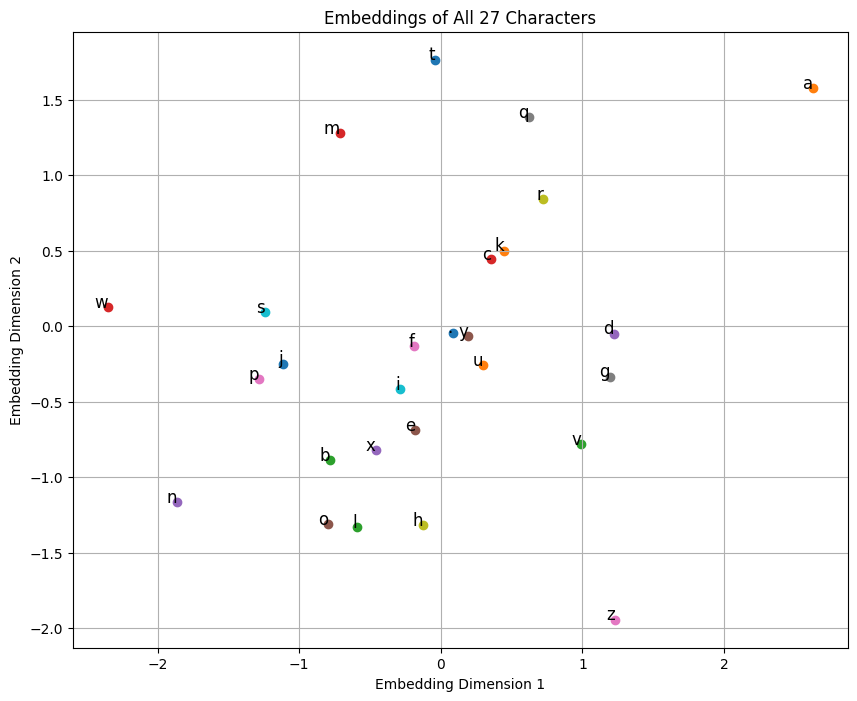

In [44]:
all_embeddings = C[:27]

# Plot embeddings
plt.figure(figsize=(10, 8))
for i in range(27):
    x, y = all_embeddings[i].tolist()
    char = itos[i]  # Get the character from index
    plt.scatter(x, y)
    plt.text(x, y, char, fontsize=12, ha='right')

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Embeddings of All 27 Characters")
plt.grid(True)
plt.show()




#### Ready for forward pass! Before that, an observation.
We know that parameters are the values which get updated during the gradient descent. A good question to ask here, is why do we have embeddings C in the parameters? Would embeddings values be updated? If so, why! Since, we never updated the one hot encodings of the inputs when we fed those as inputs to the network in our trigram model.
<br>
The reason behind this is what we have explained above. Updating these embeddings with gradient descent is what clusters the related characters closer in the 2D space. That's how the model can infer a relationship between them.

In [45]:
# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [46]:
e = 0.1
for _ in range (1000):
    # forward pass
    X_onehot = F.one_hot(X, num_classes=27).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None
    
    # Backward pass 
    loss.backward()
    
    # Update the values of the parameters 
    for p in parameters: 
        p.data -= e * p.grad

print(loss.item())

0.2556522488594055


Let's use full dataset now.

In [47]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
xs = []
ys = []

block_size = 3 # block size defines the number of characters to pass as input in order to predict the next character.
for w in words: 
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        xs.append(context)
        ys.append(stoi[ch])
        # print(''.join([itos[c] for c in context]), '--->', ch)
        context = context[1:] + [stoi[ch]] # This is a sliding window which adds the current ch to context so that the next character becomes the expected outcome


X = torch.tensor(xs)
Y = torch.tensor(ys)

In [48]:
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
B1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
B2 = torch.randn(27, generator=g)

parameters = [C, W1, B1, W2, B2]

In [49]:
# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [54]:
e = 0.1
for _ in range (50000):
    # forward pass
    ix = torch.randint(0, X.shape[0], (32, )) # We are taking batch sizes of the input data. 
    X_onehot = F.one_hot(X[ix], num_classes=27).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None
    
    # Backward pass 
    loss.backward()
    
    # Update the values of the parameters 
    for p in parameters: 
        p.data -= e * p.grad

# print(loss.item())

In [55]:
    X_onehot = F.one_hot(X, num_classes=27).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Y)
    loss

tensor(2.3900, grad_fn=<NllLossBackward0>)

### Let's look at some of the similarities that our embeddings might have captured
Let's look at which characters often start the names (are the first characters of the names). And plot them.

In [56]:
start_count = {} 
for w in words:
    start_count[w[0]] = start_count.get(w[0], 0) + 1


In [57]:
top_5_chars = sorted(start_count, key=start_count.get, reverse=True)[:5]
top_5_chars

['a', 'k', 'm', 'j', 's']

In [58]:
top_5_indices = [stoi[ch] for ch in top_5_chars]
top_5_embeddings = C[top_5_indices]
top_5_embeddings

tensor([[ 1.7321,  1.1893],
        [-0.1093, -0.2873],
        [-0.0640, -0.1144],
        [-0.0218, -0.0482],
        [ 0.1180, -0.4899]], grad_fn=<IndexBackward0>)

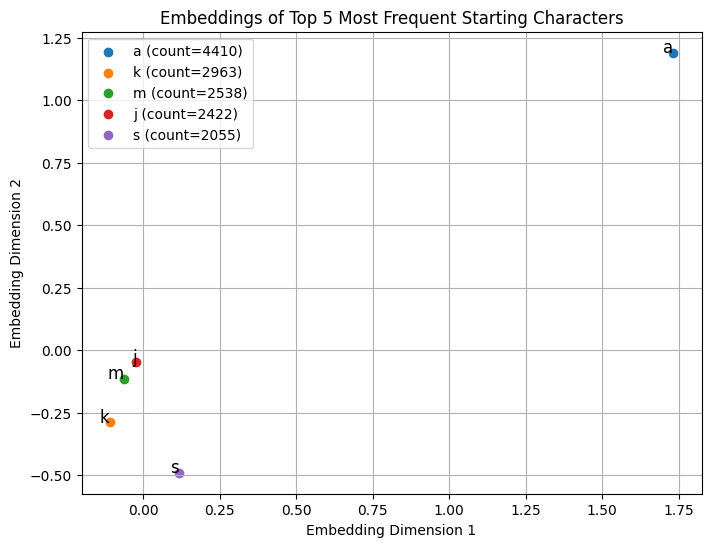

In [59]:
plt.figure(figsize=(8, 6))
for i, char in enumerate(top_5_chars):
    x, y = top_5_embeddings[i].tolist()
    plt.scatter(x, y, label=f'{char} (count={start_count[char]})')
    plt.text(x, y, char, fontsize=12, ha='right')

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Embeddings of Top 5 Most Frequent Starting Characters")
plt.legend()
plt.grid(True)
plt.show()

As you can see, the positions of j, m, k, s are clustered together. Showing that these characters are often the first character of names.
Character 'a' is an outlier here because it might also depict some other, more concrete relations with other characters. 

### Let's look at the points of all the character embeddings now. 

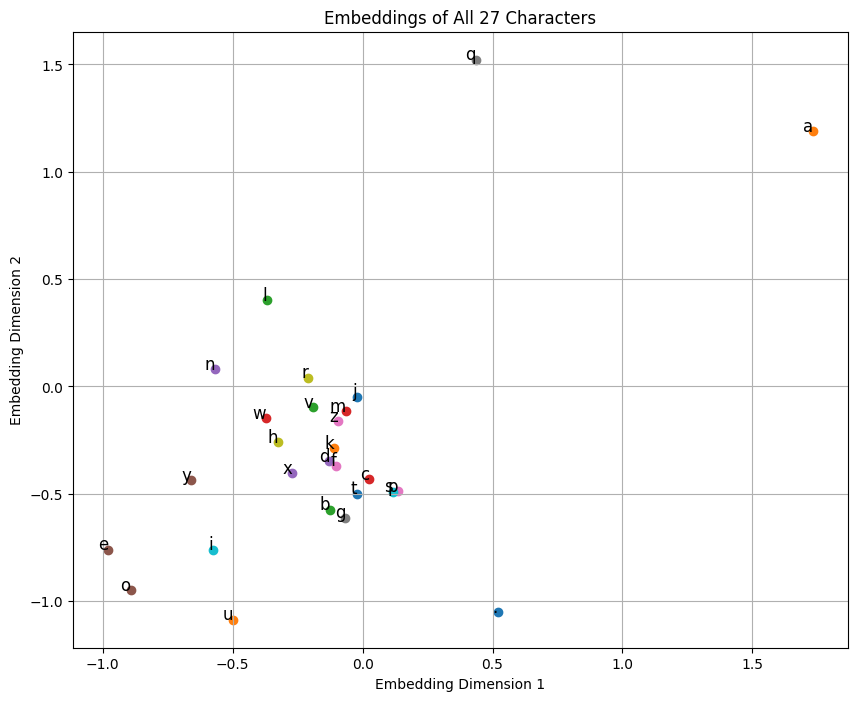

In [60]:
import matplotlib.pyplot as plt

# Assuming 'C' is the trained embedding matrix of shape [27, 2]
# 'itos' dictionary maps indices back to characters

# Retrieve all 27 embeddings
all_embeddings = C[:27]

# Plot embeddings
plt.figure(figsize=(10, 8))
for i in range(27):
    x, y = all_embeddings[i].tolist()
    char = itos[i]  # Get the character from index
    plt.scatter(x, y)
    plt.text(x, y, char, fontsize=12, ha='right')

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Embeddings of All 27 Characters")
plt.grid(True)
plt.show()


### A lot of inference that we can do from the above plot!
1. You can see that all the vowels have clustered up closer to one another.
2. All the consonants have clustered up together.
3. 'q' is an outlier, since there are very specific relations that 'q' has with other characters. Example, 'q' is most likely followed by 'u' in a word. Since no other character behaves like 'q', it is far away alone in the 2D space.

### Train test split

In [66]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [67]:
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator=g)
B1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
B2 = torch.randn(27, generator=g)

parameters = [C, W1, B1, W2, B2]

In [68]:
# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [69]:
e = 0.1
for _ in range (50000):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=27).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None
    
    # Backward pass 
    loss.backward()
    
    # Update the values of the parameters 
    for p in parameters: 
        p.data -= e * p.grad

print(loss.item())

2.1628470420837402


In [70]:
    X_onehot = F.one_hot(Xdev, num_classes=27).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ydev)
    loss

tensor(2.3691, grad_fn=<NllLossBackward0>)